In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist, mahalanobis
from sklearn.metrics import pairwise_distances

def load_data(file_path):
    data = np.loadtxt(file_path)
    return data

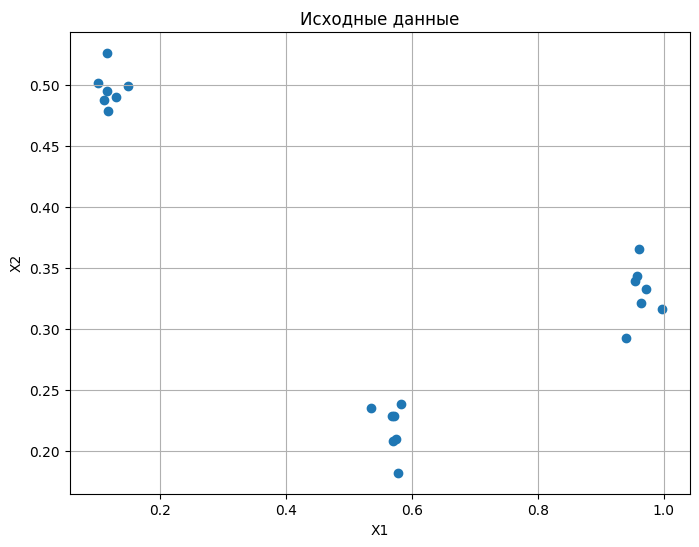

In [138]:
data = load_data("./ЛР_4/Data_Lab4/data2.txt")

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1])
plt.title("Исходные данные")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

Метрики расстояния: 1 – Евклидово, 2 – стандартизированное Евклидово, 3 – го-
рода, 4 – Махаланобиса, 5 – Минковского (p = 4), 6 –Чебышева.
** Методы связывания: a – ближнего соседа, b – дальнего соседа, c – средней связи,
d – центроидный, e – медианной связи.


1 - Евклидово
$$
d_2(n_i, n_j) = \left[ \sum_{l=1}^{K} (x_{il} - x_{jl})^2 \right]^{\frac{1}{2}}
$$


3 - метрика города (манхэттенское расстояние)

$$
d_H(n_i, n_j) = \sum_{l=1}^K |x_{il} - x_{jl}|;
$$


5 - расстояние Махалонобиса

$$
d_{\text{Mah}}(n_i, n_j) = (n_i - n_j) \mathbf{C}^{-1} (n_i - n_j)^T,
$$

In [139]:

dist_euclidean = pdist(data, metric='euclidean')

dist_manhattan = pdist(data, metric='cityblock')

# Махалонобис
cov = np.cov(data, rowvar=False)

if np.linalg.det(cov) == 0:
    inv_cov = np.linalg.pinv(cov)
else:
    inv_cov = np.linalg.inv(cov)

n = data.shape[0]
dist_mahalanobis = np.zeros((n * (n - 1)) // 2)
k = 0
for i in range(n):
    for j in range(i + 1, n):
        dist_mahalanobis[k] = mahalanobis(data[i], data[j], inv_cov)
        k += 1

distances = {
        'euclidean': dist_euclidean,
        'manhattan': dist_manhattan,
        'mahalanobis': dist_mahalanobis
    }



def perform_clustering(distances):
    results = {}
    
    for dist_name, dist_matrix in distances.items():
        results[dist_name] = {}
        
        # Ближнего соседа
        results[dist_name]['single'] = linkage(dist_matrix, method='single')
        
        # Дальнего соседа
        results[dist_name]['complete'] = linkage(dist_matrix, method='complete')
        
        results[dist_name]['centroid'] = linkage(dist_matrix, method='centroid')
    
    return results


clusterings = perform_clustering(distances)

In [140]:


def calculate_cophenetic_coefficients(distances, clusterings):
    coefficients = np.zeros((3, 3))
    
    metrics = list(distances.keys())
    methods = ['single', 'complete', 'centroid']
    
    for i, metric in enumerate(metrics):
        for j, method in enumerate(methods):
            c, _ = cophenet(clusterings[metric][method], distances[metric])
            coefficients[j, i] = c
    
    return coefficients, metrics, methods



coefficients, metrics, methods = calculate_cophenetic_coefficients(distances, clusterings)



coef_df = pd.DataFrame(coefficients, 
                        index=['Ближайший сосед', 'дальнего соседа,', 'центроидный'],
                        columns=['Ейлерово', 'Манхетена', 'Махалонобис'])
print("\nКофенетического корреляционный коэффициент:")
print(coef_df)

max_coef = np.max(coefficients)
min_coef = np.min(coefficients)
max_idx = np.unravel_index(np.argmax(coefficients), coefficients.shape)
min_idx = np.unravel_index(np.argmin(coefficients), coefficients.shape)

best_method = methods[max_idx[0]]
best_metric = metrics[max_idx[1]]
worst_method = methods[min_idx[0]]
worst_metric = metrics[min_idx[1]]

print(f"\n Лучший метод: {best_method.capitalize()} связанный {best_metric} (коэф: {max_coef:.4f})")
print(f" Худший: {worst_method.capitalize()} связанный {worst_metric} (коэф: {min_coef:.4f})")

best_clustering = clusterings[best_metric][best_method]



Кофенетического корреляционный коэффициент:
                  Ейлерово  Манхетена  Махалонобис
Ближайший сосед   0.910285   0.960191     0.973911
дальнего соседа,  0.923017   0.959047     0.967094
центроидный       0.926367   0.961471     0.974971

 Лучший метод: Centroid связанный mahalanobis (коэф: 0.9750)
 Худший: Single связанный euclidean (коэф: 0.9103)


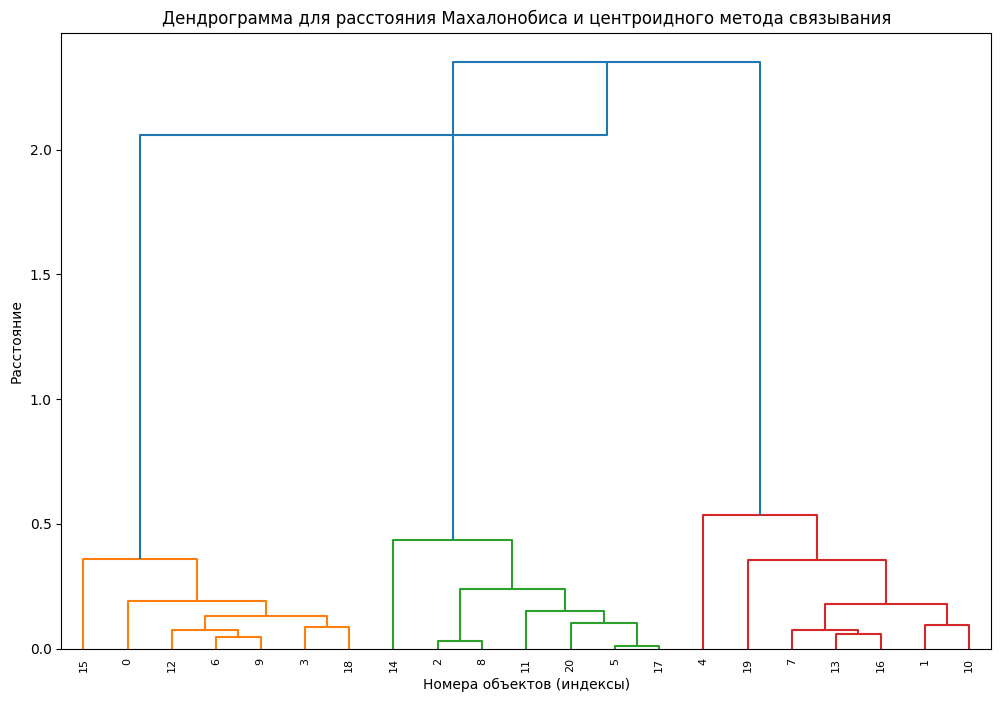

In [141]:

plt.figure(figsize=(12, 8))
plt.title(f"Дендрограмма для расстояния Махалонобиса и центроидного метода связывания")
dendrogram(
    best_clustering,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.xlabel('Номера объектов (индексы)')
plt.ylabel('Расстояние')
plt.show()

In [142]:

n_clusters = 3

cluster_labels = fcluster(best_clustering, n_clusters, criterion='maxclust')

unique_clusters = np.unique(cluster_labels)
n_clusters = len(unique_clusters)

cluster_centers = np.zeros((n_clusters, data.shape[1]))
cluster_variances = np.zeros(n_clusters)

# Центы и диссперсия
for i, cluster_id in enumerate(unique_clusters):
    cluster_data = data[cluster_labels == cluster_id]
    cluster_centers[i] = np.mean(cluster_data, axis=0)

    squared_dists = np.sum((cluster_data - cluster_centers[i])**2, axis=1)
    cluster_variances[i] = np.mean(squared_dists)

center_distances = pairwise_distances(cluster_centers, metric='euclidean')

print("\nРезультат анализа:")
print(f"Кол-во кластеров: {len(unique_clusters)}")

for i, cluster_id in enumerate(unique_clusters):
    print(f"\n Кластер {cluster_id}:")
    print(f"\t Center: {cluster_centers[i]}")
    print(f"\t Within-cluster variance: {cluster_variances[i]:.6f}")
    print(f"\t Number of points: {np.sum(cluster_labels == cluster_id)}")

print("\n Расстояние между центрами кластеров (центроидное):")
for i in range(len(unique_clusters)):
    for j in range(i+1, len(unique_clusters)):
        print(f"  Расстояние {unique_clusters[i]} и {unique_clusters[j]}: {center_distances[i, j]:.6f}")



Результат анализа:
Кол-во кластеров: 3

 Кластер 1:
	 Center: [0.11980182 0.49685281]
	 Within-cluster variance: 0.000389
	 Number of points: 7

 Кластер 2:
	 Center: [0.56867322 0.2189139 ]
	 Within-cluster variance: 0.000554
	 Number of points: 7

 Кластер 3:
	 Center: [0.96400012 0.33016288]
	 Within-cluster variance: 0.000721
	 Number of points: 7

 Расстояние между центрами кластеров (центроидное):
  Расстояние 1 и 2: 0.527954
  Расстояние 1 и 3: 0.860498
  Расстояние 2 и 3: 0.410682


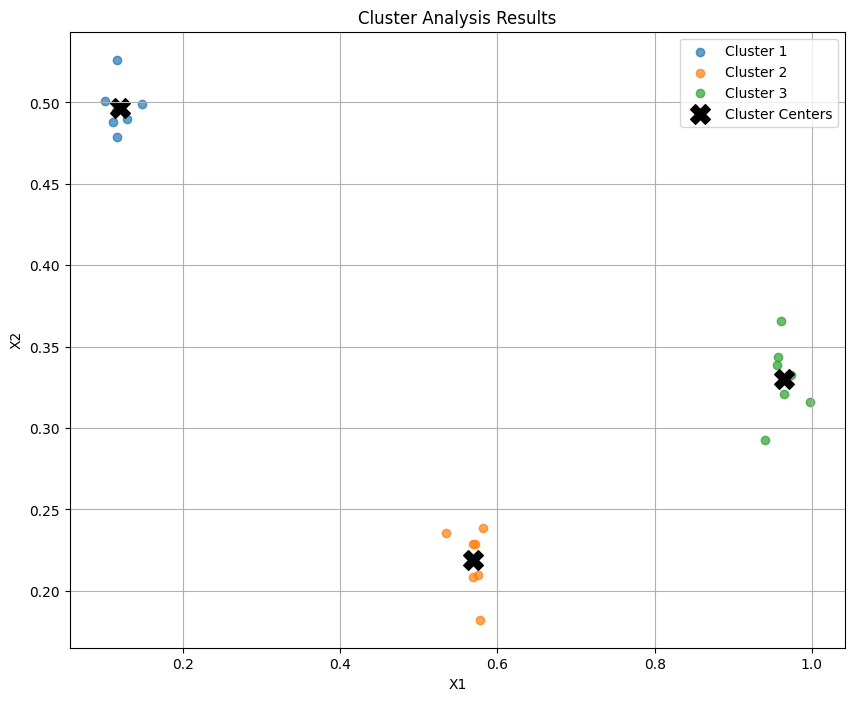

In [143]:

plt.figure(figsize=(10, 8))
    
for cluster_id in unique_clusters:
    plt.scatter(
        data[cluster_labels == cluster_id, 0],
        data[cluster_labels == cluster_id, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.7
    )

plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    s=200,
    marker='X',
    color='black',
    label='Cluster Centers'
)

plt.title('Cluster Analysis Results')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.legend()
plt.show()